# Cats vs Dogs - Transfer Learning in 30 lines with Keras

## Building a Custom Classifier in Keras with Transfer Learning

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet

import math

Using TensorFlow backend.


In [6]:
TRAIN_DATA_DIR = '../deep-learning-with-python/cats_and_dogs_small/train/'
VALIDATION_DATA_DIR = '../deep-learning-with-python/cats_and_dogs_small/validation'

TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES=2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE=64

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

val_datagen = ImageDataGenerator(rescale=1./255)

Time to load the data from its directories. Training one image at a time can be pretty inefficient, so we can batch them into groups

In [7]:
train_generator = train_datagen.flow_from_directory(
                        TRAIN_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        seed=12345,
                        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
                        VALIDATION_DATA_DIR,
                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
train_generator.class_mode

'categorical'

In [15]:
train_generator.image_shape

(224, 224, 3)

In [17]:
train_generator.samples

2000

In [13]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [12]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [11]:
validation_generator.class_indices

{'cats': 0, 'dogs': 1}

In [18]:
validation_generator.samples

1000

we will reuse a CNN previously trained on the ImageNet dataset (MobileNet in our case), throw away the last layer (ImageNet specific classifier/Softmax), and replace it with our own classifier that is suited to the task at hand.

In [8]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH,IMG_HEIGHT,3))
    
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
        
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions  = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    
    return Model(inputs=input, outputs=predictions)

In [9]:
model = model_maker()

model.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])

model.fit_generator(train_generator,
                    steps_per_epoch = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE),
                    epochs=10,
                    validation_data = validation_generator,
                    validation_steps = math.ceil(float(VALIDATION_SAMPLES) / BATCH_SIZE))

17227776/17225924 [==============================] - 14s 1us/step
Epoch 1/10
8/8 [==============================] - 95s 12s/step - loss: 0.6690 - acc: 0.6797 - val_loss: 0.1339 - val_acc: 0.9766
Epoch 2/10
8/8 [==============================] - 92s 11s/step - loss: 0.3052 - acc: 0.8730 - val_loss: 0.1757 - val_acc: 0.9447
Epoch 3/10
8/8 [==============================] - 82s 10s/step - loss: 0.2308 - acc: 0.9121 - val_loss: 0.0301 - val_acc: 0.9902
Epoch 4/10
8/8 [==============================] - 83s 10s/step - loss: 0.1557 - acc: 0.9467 - val_loss: 0.1275 - val_acc: 0.9488
Epoch 5/10
8/8 [==============================] - 74s 9s/step - loss: 0.1292 - acc: 0.9512 - val_loss: 0.0104 - val_acc: 0.9961
Epoch 6/10
8/8 [==============================] - 74s 9s/step - loss: 0.1791 - acc: 0.9395 - val_loss: 0.0842 - val_acc: 0.9734
Epoch 7/10
8/8 [==============================] - 75s 9s/step - loss: 0.1529 - acc: 0.9434 - val_loss: 0.0173 - val_acc: 0.9922
Epoch 8/10
8/8 [==================

In [10]:
model.save('model.h5')

### Test the Model

In [19]:
from keras.models import load_model

model = load_model('model.h5')

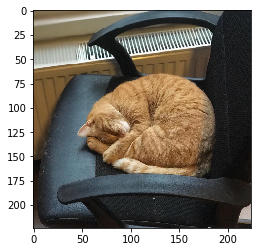

In [71]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def get_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    return img

img = get_image('samples/filafi.jpg')
plt.imshow(img)
plt.show()

In [30]:
img_array = image.img_to_array(img)
img_array.shape

(224, 224, 3)

In [38]:
expanded_img_array = img_array[np.newaxis, :, :, :]
expanded_img_array.shape

(1, 224, 224, 3)

In [39]:
expanded_img_array = img_array.reshape(-1, 224, 224, 3)
expanded_img_array.shape

(1, 224, 224, 3)

In [40]:
preprocessed_img = expanded_img_array / 255. # Preprocess the image

prediction = model.predict(preprocessed_img)

print(prediction)
print(validation_generator.class_indices)

[[0.9989196  0.00108044]]
{'cats': 0, 'dogs': 1}


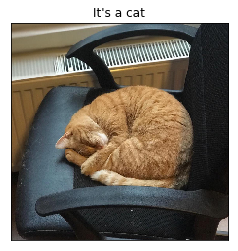

In [80]:
plt.imshow(img)

cat_or_dog = np.argmax(prediction)
title = [key[:-1] for key, value in validation_generator.class_indices.items() if value == cat_or_dog][0]

plt.title('It\'s a {}'.format(title))
plt.xticks([])
plt.yticks([]);

### Analyzing the results

In [86]:
TEST_DATA_DIR = '../deep-learning-with-python/cats_and_dogs_small/test/'

In [87]:
test_datagen = ImageDataGenerator(
        rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        TEST_DATA_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=64,
        shuffle=False,
        class_mode='categorical')

ground_truth = test_generator.classes

Found 1000 images belonging to 2 classes.


In [89]:
ground_truth.shape

(1000,)

In [90]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [93]:
len(test_generator)

16

In [94]:
predictions = model.predict_generator(test_generator, steps=len(test_generator))

In [95]:
predictions.shape

(1000, 2)

In [96]:
predictions

array([[9.9998021e-01, 1.9750732e-05],
       [9.9999905e-01, 9.6608255e-07],
       [9.9979955e-01, 2.0052255e-04],
       ...,
       [9.9999833e-01, 1.7049260e-06],
       [9.9923766e-01, 7.6239201e-04],
       [9.9997246e-01, 2.7510861e-05]], dtype=float32)

In [110]:
len(test_generator.filenames)

1000

In [114]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, (val,f_name) in enumerate(zip(predictions, test_generator.filenames)):
    #get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability, index_of_highest_probability, ground_truth[index], f_name]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [139]:
# Helper function that finds images that are closest
# Input parameters:
#   prediction_table: dictionary from the image index to the prediction and ground truth for that image
#   get_highest_probability: boolean flag to indicate if the results need to be highest (True) or lowest (False) probabilities
#   label: id of category
#   number_of_items: num of results to return
#   only_false_predictions: boolean flag to indicate if results should only contain incorrect predictions
def get_images_with_sorted_probabilities(prediction_table, get_highest_probability, label, number_of_items, only_false_predictions=False):
    sorted_prediction_table = [ (k, prediction_table[k]) for k in
    sorted(prediction_table, key=prediction_table.get, reverse= get_highest_probability)]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt, fn] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append([image_index, [probability, predicted_index, gt, fn] ])
            else:
#                 if predicted_index == gt:
                result.append([image_index, [probability, predicted_index, gt, fn] ])
        if len(result) >= number_of_items:
            return result

In [133]:
# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20,15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title( "\n\n"+  filenames[i].split("/")[-1]+"\n"+"\nProbability: " +
        str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle( message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)


def display(sorted_indicies, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indicies:
        [probability, predicted_index, gt, fn] = value
        similar_image_paths.append(TEST_DATA_DIR + value[3])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

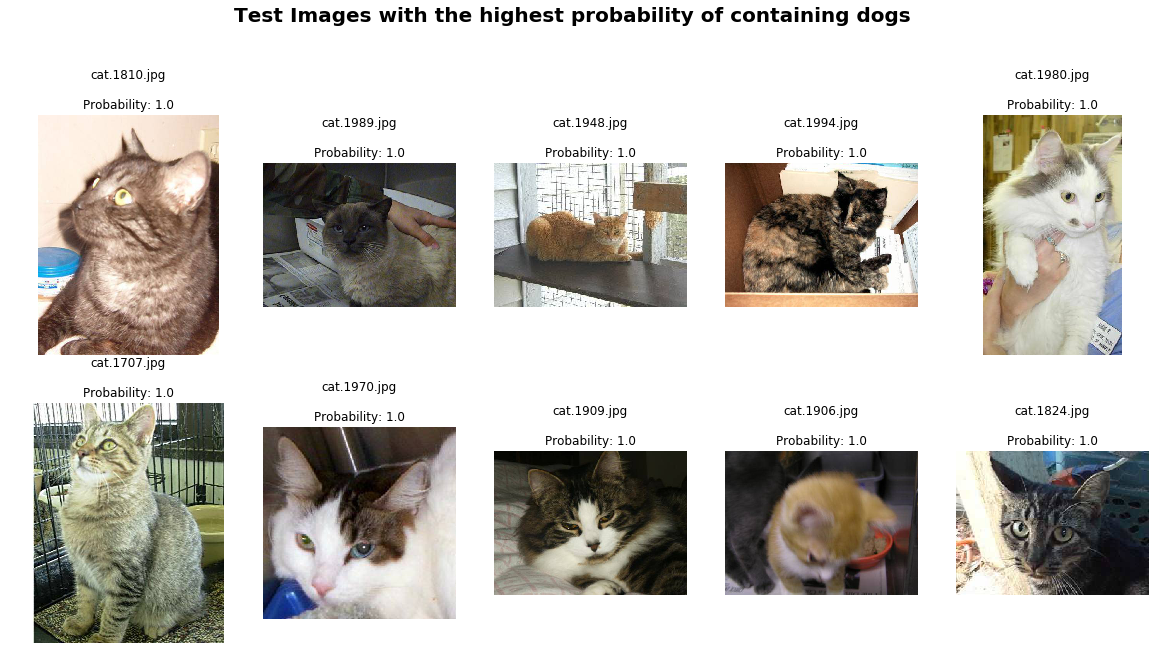

In [146]:
# Most confident predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table, True, 1, 10, False)
message = 'Test Images with the highest probability of containing dogs'
display(indices[:10], message)

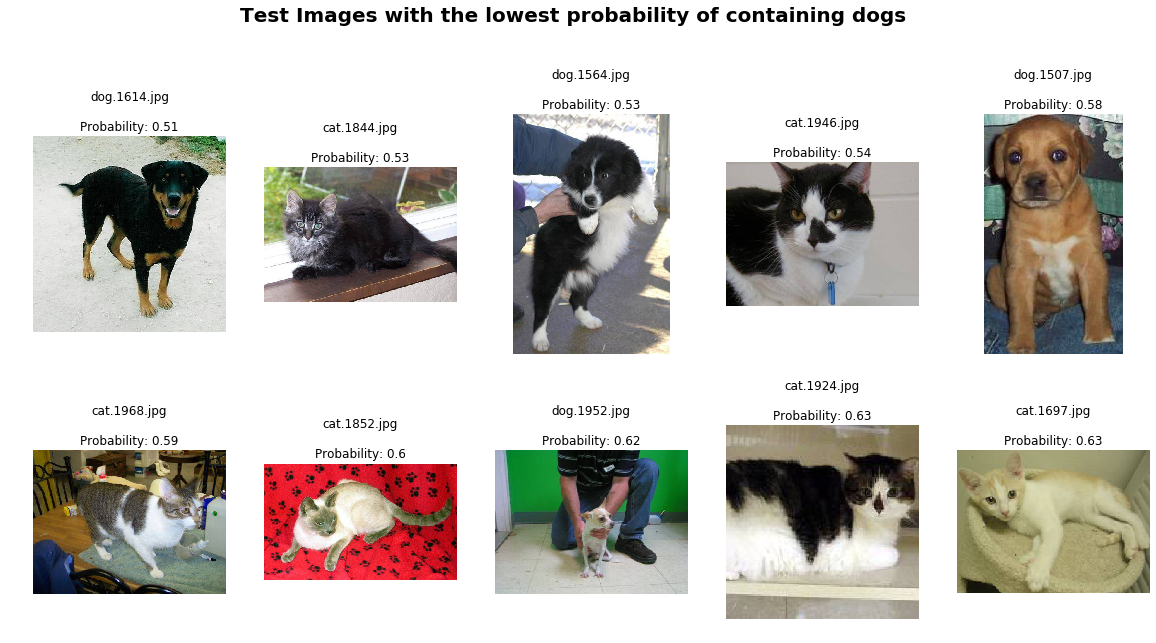

In [147]:
# Least confident predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table, False, 1, 10, False)
message = 'Test Images with the lowest probability of containing dogs'
display(indices[:10], message)

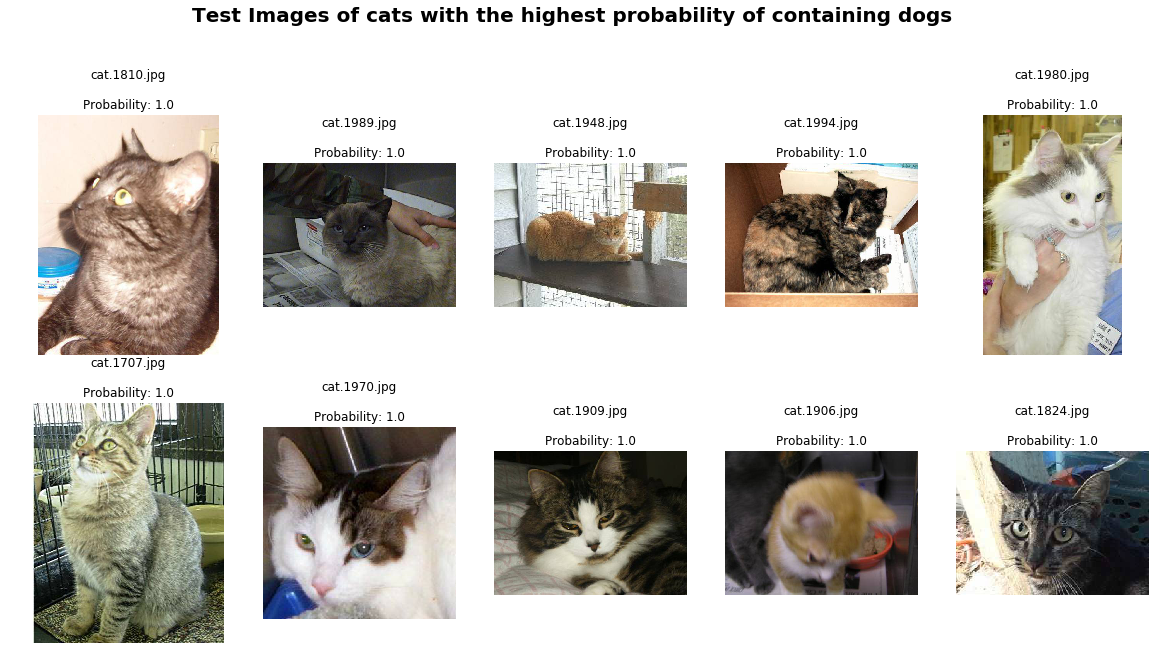

In [148]:
# Incorrect predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table, True, 1, 10, True)
message = 'Test Images of cats with the highest probability of containing dogs'
display(indices[:10], message)

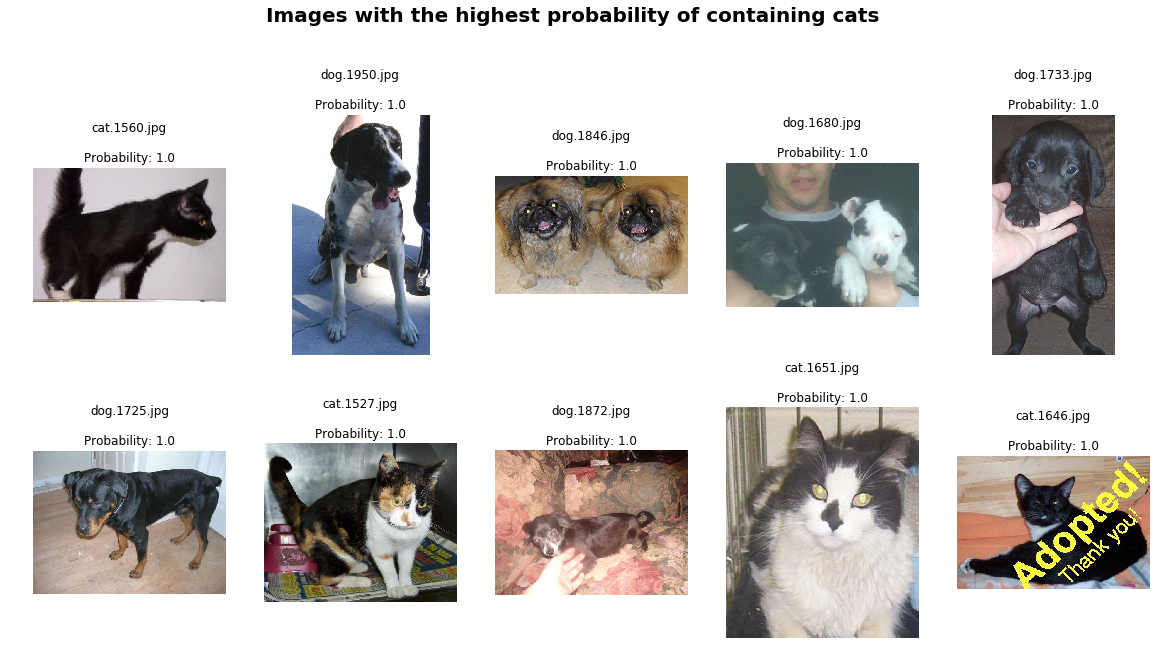

In [142]:
# Most confident predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table, True, 0, 10, False)
message = 'Images with the highest probability of containing cats'
display(indices[:10], message)

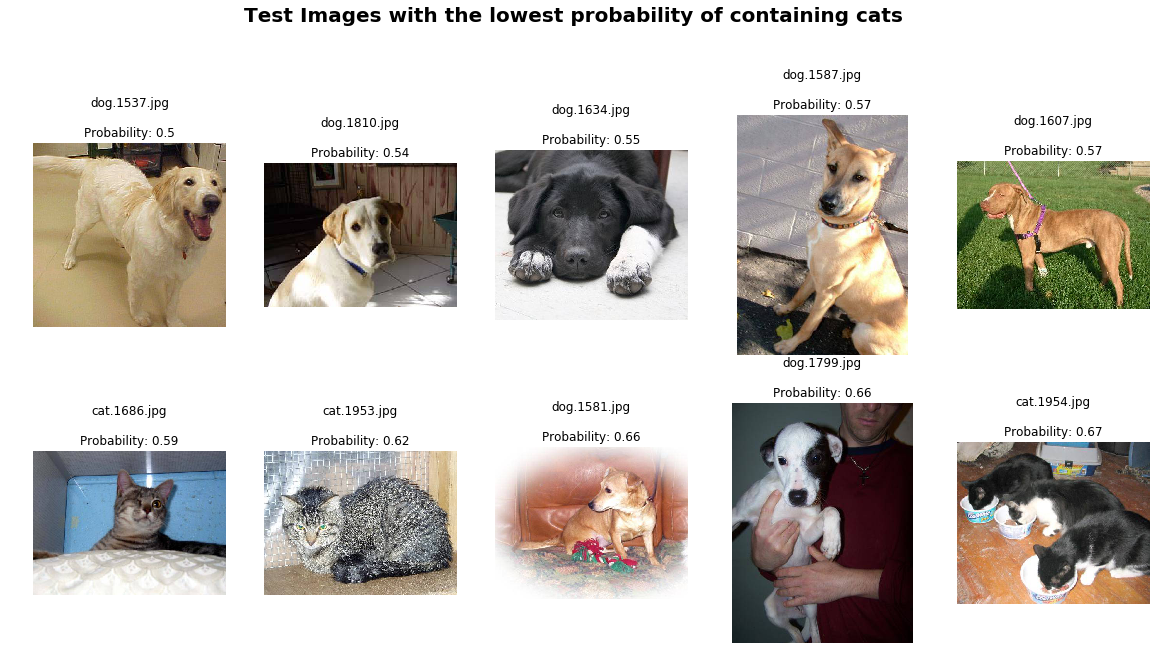

In [149]:
# Least confident predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table, False, 0, 10, False)
message = 'Test Images with the lowest probability of containing cats'
display(indices[:10], message)

Like previously seen, the key object size is small, and some of the images are quite unclear meaning there is too much contrast in some cases or the object is too bright, something not in line with most of the training images

which images is our classifier mistakenly sure of containing cats?

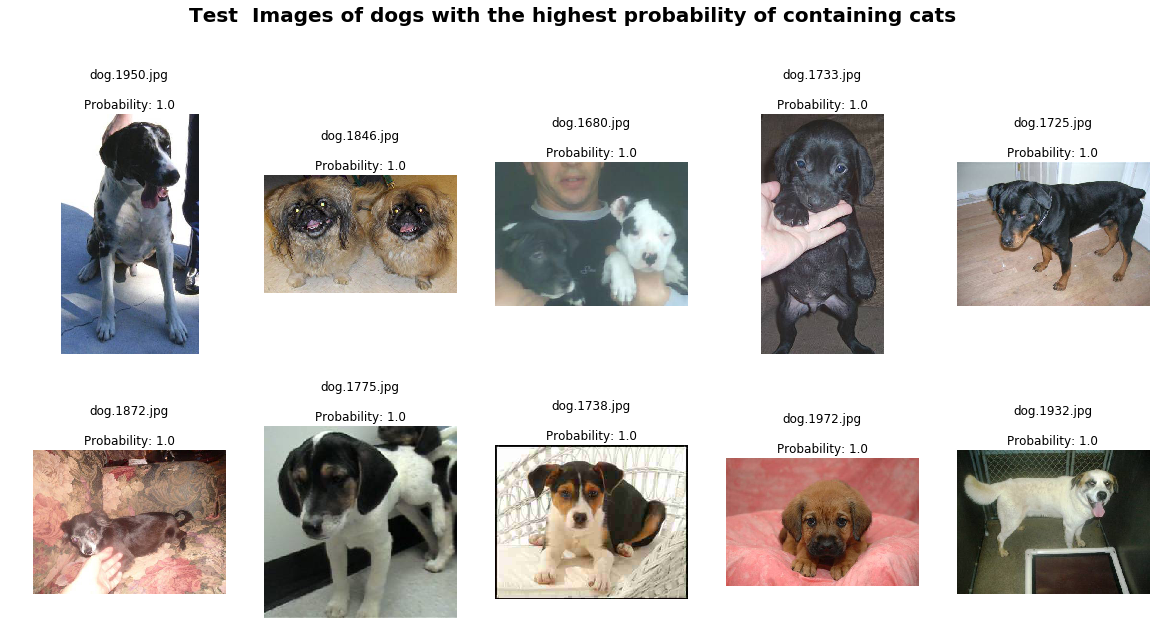

In [150]:
# Incorrect predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table, True, 0, 10, True)
message = 'Test Images of dogs with the highest probability of containing cats'
display(indices[:10], message)

These mispredictions are what we want to reduce